In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis, pdist, squareform
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError
import warnings
from collections import Counter
import scipy.stats
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "2"  # Limit to 2 threads
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"

In [3]:
warnings.filterwarnings("ignore")

In [4]:
%cd /home/zuzannak/MicroFormer/

/home/zuzannak/MicroFormer


In [5]:
torch.cuda.empty_cache()

In [6]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [7]:
taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
pathways = pd.read_csv('inputs/pathways.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
metadata = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()
metadata = metadata[metadata['sample_id'].isin(taxonomy.index)]

metadata['SICK'] = np.where(metadata.disease == 'healthy', 0, 1)

#get only a small group
#keep_samples = metadata[(metadata['SICK'] == 0) & (metadata['age_category'] == 'adult')].drop_duplicates('sample_id', keep='first').sample(5000, random_state=42).sample_id.values
keep_samples = metadata[(metadata['age_category'] == 'adult')].drop_duplicates('sample_id', keep='first').sample(8000, random_state=42).sample_id.values

taxonomy = taxonomy.loc[keep_samples]
pathways = pathways.loc[keep_samples].iloc[:, 2:].dropna()

In [8]:
## Filter low abundance bacteria
def filter_prevalence(df, treshold = 00):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-5):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_taxonomy = filter_on_abundance(filter_prevalence(taxonomy, 0), 1e-5)
filtered_pathways = filter_on_abundance(filter_prevalence(pathways, 0), 1e-5)

filtered_taxonomy = filtered_taxonomy[~filtered_taxonomy.index.duplicated(keep='first')]
filtered_pathways = filtered_pathways[~filtered_pathways.index.duplicated(keep='first')]

filtered_taxonomy = filtered_taxonomy.div(filtered_taxonomy.sum(axis=1), axis=0)
filtered_pathways = filtered_pathways.div(filtered_pathways.sum(axis=1), axis=0)

filtered_pathways = filtered_pathways.dropna()
filtered_taxonomy = filtered_taxonomy.loc[filtered_pathways.index]

In [9]:
filtered_pathways = np.log(filtered_pathways+1e-3)
filtered_taxonomy = np.log(filtered_taxonomy+1e-3)

In [10]:
filtered_pathways.shape, filtered_taxonomy.shape

((7989, 397), (7989, 341))

In [11]:
filtered_pathways.isna().sum().sum(), filtered_taxonomy.isna().sum().sum()

(np.int64(0), np.int64(0))

In [12]:
class BacteriaModel(nn.Module):
    def __init__(self, num_pathways, num_bacteria, embedding_dim, latent_size):
        super(BacteriaModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.latent_size = latent_size
        
        # Bacteria encoding
        self.pathways_embedding = nn.Embedding(num_pathways, embedding_dim) #czy wektory embeddingow koreluje z filogenetyka czy on mimo braku informacji rozumie filogenetyke
        self.taxonomy_embedding = nn.Embedding(num_bacteria, embedding_dim) #czy wektory embeddingow koreluje z filogenetyka czy on mimo braku informacji rozumie filogenetyke
        
        # Linear layer to transform (B, #Bac, 1) to (B, #Bac, D)
        self.linear_layer = nn.Linear(1, embedding_dim)
        
        # Transformer encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

        self.final_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=embedding_dim)
        self.final_transformer_encoder = nn.TransformerEncoder(self.final_encoder_layer, num_layers=1)
        
        # Mean and Logvar layers
        self.mean_layer = nn.Linear(embedding_dim, latent_size)
        self.mu_layer = nn.Linear(embedding_dim, latent_size)
        
        # Linear transformation for latent vector
        self.linear_transform = nn.Linear(latent_size, embedding_dim)
        
        # Transformer decoder
        self.decoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8) #zastapic encoder
        self.transformer_decoder = nn.TransformerEncoder(self.decoder_layer, num_layers=1) # zamienić na 1 warstwę
        
        # Final linear layer to transform (B, #Bac, D) to (B, #Bac, 1)
        self.output_transform = nn.Linear(embedding_dim, 1)
        self.softmax = nn.Softmax(dim=1)
    
    def reparameterize(self, mean, log_var):
        batch, dim = mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(mean.device)
        return mean + torch.exp(0.5 * log_var) * epsilon
    
    def forward(self, pathways_tensor, bacteria_tensor):
        
        batch_size = pathways_tensor.size(0)
        num_pathways = pathways_tensor.size(1)
        num_bacteria = bacteria_tensor.size(1)

        # Step 1: Transform (B, #Bac, 1) to (B, #Bac, D)
        pathways_transformed = self.linear_layer(pathways_tensor)
        bacteria_transformed = self.linear_layer(bacteria_tensor)
        
        # Step 2: Create bacteria encoding
        pathways_indices = torch.arange(num_pathways).to(pathways_tensor.device)
        pathways_encoded = self.pathways_embedding(pathways_indices)
        bacteria_indices = torch.arange(num_bacteria).to(bacteria_tensor.device)
        bacteria_encoded = self.pathways_embedding(bacteria_indices)
        
        # Expand bacteria encoding to match batch size and add to bacteria_transformed
        pathways_encoded_expanded = pathways_encoded.unsqueeze(0).expand(batch_size, -1, -1)
        result = pathways_transformed + pathways_encoded_expanded
        bacteria_encoded_expanded = bacteria_encoded.unsqueeze(0).expand(batch_size, -1, -1)
        bacteria_result = bacteria_transformed + bacteria_encoded_expanded
        
        # Step 3: Pass through Transformer encoder
        result_transposed = result.permute(1, 0, 2)  # (S, N, E)
        bacteria_result_transposed = result.permute(1, 0, 2)  # (S, N, E)
        output = self.transformer_encoder(result_transposed)
        output = self.final_transformer_encoder(result_transposed)
        
        # Step 4: Average over sequence (mean along the sequence dimension)
        mean_vector = output.mean(dim=0)
        
        # Step 5: Compute mean and logvar
        mean = self.mean_layer(mean_vector)
        logvar = self.mu_layer(mean_vector)
        
        # Step 6: Reparameterize to get latent vector z
        z = self.reparameterize(mean, logvar)

        # Step 7: Transform z to (B, D)
        D_vector = self.linear_transform(z)
        
        # Step 8: Repeat D_vector for each bacterium to match (B, #Bac, D)
        D_vector_expanded = D_vector.unsqueeze(1).repeat(1, num_pathways, 1)
        result_with_encoding = D_vector_expanded + pathways_encoded_expanded

        D_vector_expanded_taxonomy = D_vector.unsqueeze(1).repeat(1, num_bacteria, 1)
        bacteria_result_with_encoding = D_vector_expanded_taxonomy + bacteria_encoded_expanded
        
        # Step 9: Pass through Transformer decoder
        result_with_encoding = result_with_encoding.permute(1, 0, 2)  # (S, N, E)
        bacteria_result_with_encoding = bacteria_result_with_encoding.permute(1, 0, 2)  # (S, N, E)

        output = self.transformer_decoder(result_with_encoding) #zamienic na encoder i usunąć
        bacteria_output = self.transformer_decoder(bacteria_result_with_encoding) #zamienic na encoder i usunąć
        
        # Step 10: Transform output to (B, #Bac, 1)
        output = output.permute(1, 0, 2)  # Back to (B, #Bac, D)
        output_transformed = self.output_transform(output)

        bacteria_output = bacteria_output.permute(1, 0, 2)  # Back to (B, #Bac, D)
        bacteria_output_transformed = self.output_transform(bacteria_output)
        
        #bacteria_output_transformed = self.softmax(bacteria_output_transformed)
        #output_transformed = self.softmax(output_transformed) 
        
        return bacteria_output_transformed, output_transformed, mean, logvar, z

# Add the discriminator component
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)  # Binary classifier
        )
        
    def forward(self, z):
        return self.fc(z)

# FactorVAE loss
def loss_function(bacteria, bacteria_hat, pathways, pathways_hat, mean, logvar, z, discriminator, permuted_z, gamma=30):
    
    bacteria_loss = nn.functional.mse_loss(bacteria_hat, bacteria, reduction='sum') 
    pathways_loss = nn.functional.mse_loss(pathways_hat, pathways, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    # Discriminator loss
    pred = discriminator(z)
    pred_permuted = discriminator(permuted_z)
    
    discriminator_loss = nn.CrossEntropyLoss()(pred, torch.ones(pred.size(0)).long().to(DEVICE)) + \
                         nn.CrossEntropyLoss()(pred_permuted, torch.zeros(pred_permuted.size(0)).long().to(DEVICE))
    
    # Total loss with gamma
    return bacteria_loss + pathways_loss + KLD*1e-3 + gamma * discriminator_loss

In [13]:
# Function to compute off-diagonal loss (covariance regularization)
def covariance_penalty(z):
    # z is of shape (batch_size, latent_dim)
    cov_matrix = torch.cov(z.T)
    # Compute the off-diagonal penalty (sum of absolute off-diagonal elements)
    off_diag_penalty = torch.sum(torch.abs(cov_matrix - torch.diag(torch.diag(cov_matrix))))
    return off_diag_penalty

# Update your loss function to include the covariance penalty
def loss_function(bacteria, bacteria_hat, pathways, pathways_hat, mean, logvar, z, discriminator, permuted_z, epoch, gamma=50, kl_weight=1, bacteria_weight=10, pathways_weight=10, cov_penalty_weight=1.0):
    
    # Reconstruction losses
    bacteria_loss = nn.functional.mse_loss(bacteria_hat, bacteria, reduction='sum') 
    pathways_loss = nn.functional.mse_loss(pathways_hat, pathways, reduction='sum')

    # KL Divergence with annealing
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Discriminator loss
    pred = discriminator(z)
    pred_permuted = discriminator(permuted_z)
    
    discriminator_loss = nn.CrossEntropyLoss()(pred, torch.ones(pred.size(0)).long().to(DEVICE)) + \
                         nn.CrossEntropyLoss()(pred_permuted, torch.zeros(pred_permuted.size(0)).long().to(DEVICE))

    # Add covariance regularization to encourage disentanglement
    cov_penalty = covariance_penalty(z)

    # Total loss with scaled terms and covariance penalty
    return bacteria_loss*bacteria_weight + pathways_loss*pathways_weight + kl_weight * KLD + gamma * discriminator_loss + cov_penalty_weight * cov_penalty


In [14]:
# Prepare the data
X_train_taxonomy, X_test_taxonomy = train_test_split(filtered_taxonomy, test_size=0.2, random_state=0)
X_train_pathways, X_test_pathways = train_test_split(filtered_pathways, test_size=0.2, random_state=0)

batch_size = 32

# Prepare the data
X_train_taxonomy_tensor = torch.tensor(X_train_taxonomy.values).float().unsqueeze(-1)  
X_train_taxonomy_dataloader = DataLoader(X_train_taxonomy_tensor,
                                         batch_size=batch_size,
                                         shuffle=False)

X_train_pathways_tensor = torch.tensor(X_train_pathways.values).float().unsqueeze(-1)  
X_train_pathways_dataloader = DataLoader(X_train_pathways_tensor,
                                         batch_size=batch_size,
                                         shuffle=False)

X_test_taxonomy_tensor = torch.tensor(X_test_taxonomy.values).float().unsqueeze(-1)  
X_test_taxonomy_dataloader = DataLoader(X_test_taxonomy_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)  

X_test_pathways_tensor = torch.tensor(X_test_pathways.values).float().unsqueeze(-1)  
X_test_pathways_dataloader = DataLoader(X_test_pathways_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)  

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
# Model instantiation
embedding_dim = 256
latent_dim = 8
num_bacteria = filtered_taxonomy.shape[1]
num_pathways = filtered_pathways.shape[1]

model = BacteriaModel(num_pathways, num_bacteria, embedding_dim, latent_dim).to(DEVICE)
discriminator = Discriminator(latent_dim).to(DEVICE)

criterion = nn.MSELoss()
metric = MeanSquaredError()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
early_stopper = EarlyStopper(patience=3, min_delta=10)
gamma = 30 

# Training loop
history = []
num_epochs = 100
for epoch in range(num_epochs):
    print(epoch)
    
    model.train()
    discriminator.train()
    
    training_loss = 0.0
    train_step    = 0.0
    train_taxonomy_mse = 0.0
    train_pathways_mse = 0.0
    
    for xT, xP in zip(X_train_taxonomy_dataloader, X_train_pathways_dataloader):
        
        xT = xT.to(DEVICE)
        xP = xP.to(DEVICE)
        
        optimizer.zero_grad()     
        discriminator_optimizer.zero_grad()

        xT_pred, xP_pred, mean, logvar, z = model(xP, xT)
        
        permuted_z = z[torch.randperm(z.size(0))].to(DEVICE)
        pred = discriminator(z)
        pred_permuted = discriminator(permuted_z)
        
        #loss = loss_function(xT, xT_pred, xP, xP_pred, mean, logvar)  
        loss = loss_function(xT, xT_pred, xP, xP_pred, mean, logvar, z, discriminator, permuted_z, gamma)

        taxonomy_mse = nn.functional.mse_loss(xT_pred, xT, reduction='sum')
        pathways_mse = nn.functional.mse_loss(xP_pred, xP, reduction='sum')

        
        loss.backward(retain_graph=True)
        optimizer.step()
        #discriminator_optimizer.step()
        
        training_loss += loss.item()
        train_taxonomy_mse += taxonomy_mse.item()
        train_pathways_mse += pathways_mse.item()
        train_step += 1

    model.eval()
    discriminator.eval()
    
    test_loss = 0.0 
    test_steps = 0.0
    test_taxonomy_mse = 0.0
    test_pathways_mse = 0.0
    with torch.no_grad():
        
        for xT, xP in zip(X_train_taxonomy_dataloader, X_train_pathways_dataloader):
            
            xT = xT.to(DEVICE)
            xP = xP.to(DEVICE)
        
            xT_pred, xP_pred, mean, logvar, z = model(xP, xT)
            permuted_z = z[torch.randperm(z.size(0))].to(DEVICE)
            pred = discriminator(z)
            pred_permuted = discriminator(permuted_z)
            
            #loss = loss_function(xT, xT_pred, xP, xP_pred, mean, logvar)  
            loss = loss_function(xT, xT_pred, xP, xP_pred, mean, logvar, z, discriminator, permuted_z, gamma)
            
            #loss = loss_function(xT, xT_pred, xP, xP_pred, mean, logvar)
            
            taxonomy_mse = nn.functional.mse_loss(xT_pred, xT, reduction='sum')
            pathways_mse = nn.functional.mse_loss(xP_pred, xP, reduction='sum')
            
            test_loss += loss.item()
            test_taxonomy_mse += taxonomy_mse.item()
            test_pathways_mse += pathways_mse.item()
            test_steps += 1
            
            if early_stopper.early_stop(test_loss):             
                break
                
    history.append({"epoch":epoch,
                    "train_loss":training_loss/train_step,
                    "train_taxonomy_mse":train_taxonomy_mse/train_step,
                    "train_pathways_mse":train_pathways_mse/train_step,
                    "test_loss":test_loss/test_steps,
                    "test_taxonomy_mse":test_taxonomy_mse/train_step,
                    "test_pathways_mse":test_pathways_mse/train_step})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
#torch.save(model.state_dict(), 'pretrained_models/pathways_to_taxonomy_transformer.pt')

In [18]:
torch.cuda.empty_cache()

In [19]:
history_df = pd.DataFrame(history).iloc[10:]

<Axes: xlabel='epoch', ylabel='train_loss'>

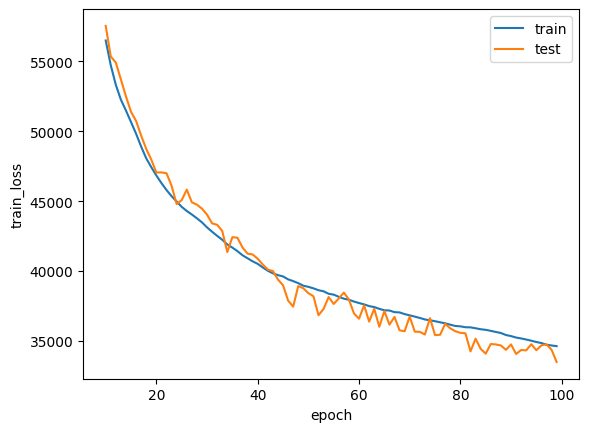

In [20]:
sns.lineplot(data=history_df, x = 'epoch', y = 'train_loss', label = 'train')
sns.lineplot(data=history_df, x = 'epoch', y = 'test_loss', label='test')

In [21]:
model = model.cpu()
model.eval()

BacteriaModel(
  (pathways_embedding): Embedding(397, 256)
  (taxonomy_embedding): Embedding(341, 256)
  (linear_layer): Linear(in_features=1, out_features=256, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_fea

In [22]:
full_taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
full_pathways = pd.read_csv('inputs/pathways.csv', index_col= [0], low_memory=False).fillna(0).sort_index()

keep_samples = metadata[(metadata['SICK'] == 0) & \
                        (metadata['age_category'] == 'adult') & \
                        ~(metadata['sample_id'].isin(taxonomy.index))].drop_duplicates('sample_id', keep='first').sample(50, random_state=42).sample_id.values

val_taxonomy = full_taxonomy.loc[keep_samples][filtered_taxonomy.columns]
val_pathways = full_pathways.loc[keep_samples][filtered_pathways.columns]

val_taxonomy = val_taxonomy.div(val_taxonomy.sum(axis=1), axis=0).sort_index()
val_pathways = val_pathways.div(val_pathways.sum(axis=1), axis=0).sort_index()

val_taxonomy = np.log(val_taxonomy+1e-3)
val_pathways = np.log(val_pathways+1e-3)

X_val_taxonomy_tensor = torch.tensor(val_taxonomy.values).float().unsqueeze(-1)#.to(DEVICE)
X_val_pathways_tensor = torch.tensor(val_pathways.values).float().unsqueeze(-1)#.to(DEVICE) 

xT_pred, xP_pred, mean, logvar, z = model(X_val_pathways_tensor, X_val_taxonomy_tensor)

In [23]:
xP_pred_df = pd.DataFrame(xP_pred.cpu().detach().numpy()[:, :, 0])
xP_true_df = pd.DataFrame(val_pathways.values)

xP_pred_df['data'] = 'pred'
xP_true_df['data'] = 'true'

X = pd.concat([xP_pred_df.set_index('data'), xP_true_df.set_index('data')])
distance_matrix = np.nan_to_num(squareform(pdist(X)), 0.5)
pcoa_df = pcoa(distance_matrix).samples

<Axes: >

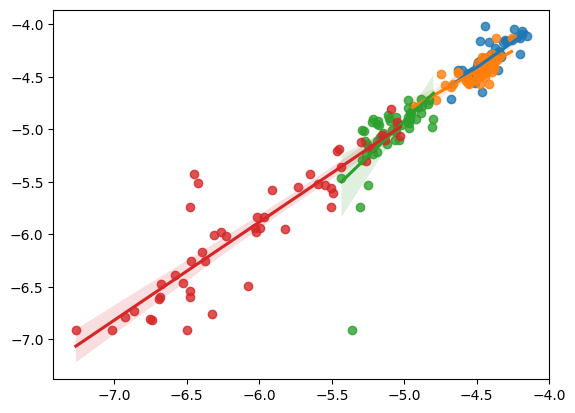

In [24]:
#sns.regplot(x = xP_pred_df.iloc[:, 0].values, y = xP_true_df.iloc[:, 0].values)
sns.regplot(x = xP_pred_df.iloc[:,10].values, y = xP_true_df.iloc[:, 10].values)
sns.regplot(x = xP_pred_df.iloc[:,20].values, y = xP_true_df.iloc[:, 20].values)
sns.regplot(x = xP_pred_df.iloc[:,60].values, y = xP_true_df.iloc[:, 60].values)
sns.regplot(x = xP_pred_df.iloc[:,87].values, y = xP_true_df.iloc[:, 87].values)

<Axes: >

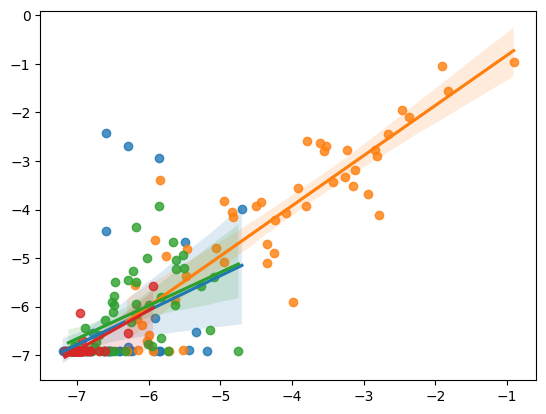

In [25]:
xT_pred_df = pd.DataFrame(xT_pred.cpu().detach().numpy()[:, :, 0])
xT_true_df = pd.DataFrame(val_taxonomy.values)

sns.regplot(x = xT_pred_df.iloc[:,10].values, y = xT_true_df.iloc[:, 10].values)
sns.regplot(x = xT_pred_df.iloc[:,20].values, y = xT_true_df.iloc[:, 20].values)
sns.regplot(x = xT_pred_df.iloc[:,60].values, y = xT_true_df.iloc[:, 60].values)
sns.regplot(x = xT_pred_df.iloc[:,87].values, y = xT_true_df.iloc[:, 87].values)

In [26]:
taxonomy_pred = pd.DataFrame(xT_pred[:, :, 0].cpu().detach().numpy(), columns = val_taxonomy.columns, index=val_taxonomy.index)
pathways_pred = pd.DataFrame(xP_pred[:, :, 0].cpu().detach().numpy(), columns = val_pathways.columns, index=val_pathways.index)

In [27]:
def prepare_pcoa_df(true_data, pred_data, label):
    """
    Concatenate true and predicted data, compute distance matrix, and return PCoA results.
    
    Parameters:
    - true_data: DataFrame containing the true values
    - pred_data: DataFrame containing the predicted values
    - label: Label for the index ('taxonomy' or 'pathways')
    
    Returns:
    - pcoa_df: DataFrame containing the PCoA coordinates
    """
    # Label the datasets as 'true' and 'pred'
    true_data.loc[:, 'data'] = 'true'
    pred_data.loc[:, 'data'] = 'pred'
    
    # Concatenate the two DataFrames based on the 'data' index
    combined_data = pd.concat([true_data.set_index('data'), pred_data.set_index('data')])
    combined_data = (combined_data)
    # Optionally, you can uncomment the line below to ensure all values are non-negative
    # combined_data[combined_data < 0] = 0
    
    # Compute pairwise distances and apply PCoA
    distance_matrix = squareform(pdist(combined_data))
    distance_matrix = np.nan_to_num(distance_matrix, 0.5)
    pcoa_df = pcoa(distance_matrix).samples
    
    return pcoa_df, combined_data.index

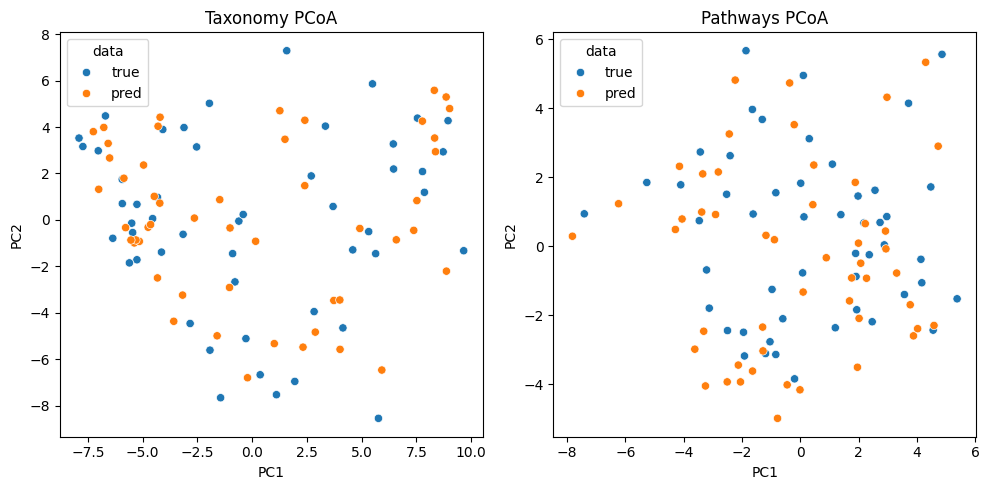

In [28]:
# Prepare PCoA results for both taxonomy and pathways
pcoa_df_taxonomy, taxonomy_labels = prepare_pcoa_df(val_taxonomy, taxonomy_pred, 'taxonomy')
pcoa_df_pathways, pathways_labels = prepare_pcoa_df(val_pathways, pathways_pred, 'pathways')

# Create subplots for taxonomy and pathways
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot PCoA for taxonomy
sns.scatterplot(x=pcoa_df_taxonomy.PC1, y=pcoa_df_taxonomy.PC2, hue=taxonomy_labels, ax=axes[0])
axes[0].set_title('Taxonomy PCoA')

# Plot PCoA for pathways
sns.scatterplot(x=pcoa_df_pathways.PC1, y=pcoa_df_pathways.PC2, hue=pathways_labels, ax=axes[1])
axes[1].set_title('Pathways PCoA')

plt.tight_layout()
plt.show()

In [29]:
# Count total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10716689


<Axes: ylabel='Count'>

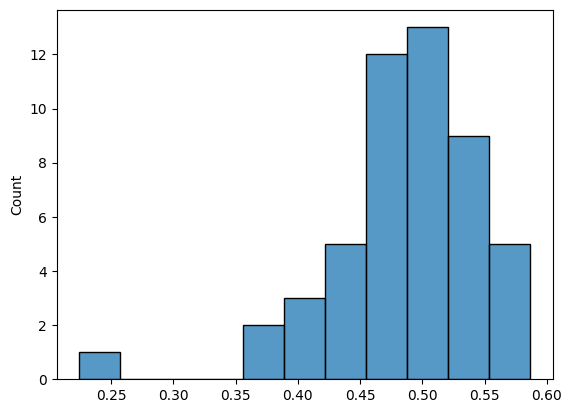

In [30]:
corr_coeffs_l = [scipy.stats.kendalltau(taxonomy_pred.iloc[i, :-1], val_taxonomy.iloc[i, :-1])[0]  for i in range(len(val_taxonomy))]
sns.histplot(corr_coeffs_l)

<Axes: ylabel='Count'>

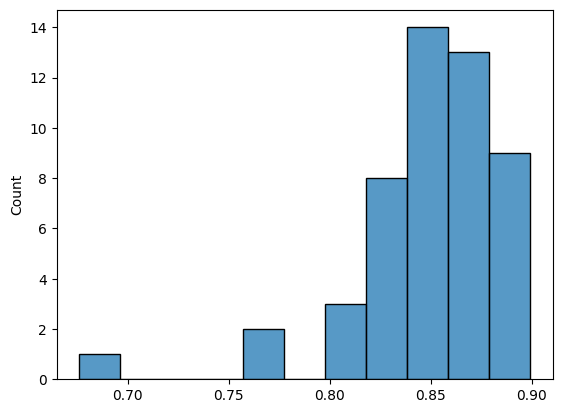

In [31]:
corr_coeffs_l = [scipy.stats.kendalltau(pathways_pred.iloc[i, :-1], val_pathways.iloc[i, :-1])[0]  for i in range(len(val_pathways))]
sns.histplot(corr_coeffs_l)

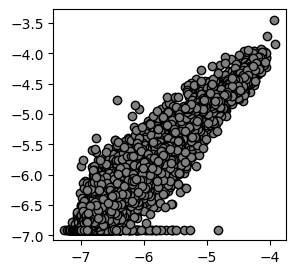

In [32]:
plt.figure(figsize = (3, 3))
[plt.plot(pathways_pred.iloc[i, :-1], val_pathways.iloc[i, :-1], color='black',marker='o',markerfacecolor='grey',linestyle='')  for i in range(len(val_pathways))]
plt.show()

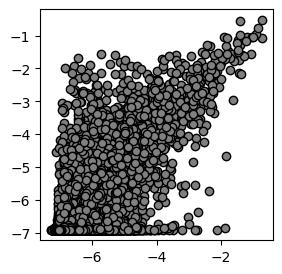

In [33]:
plt.figure(figsize = (3, 3))
[plt.plot(taxonomy_pred.iloc[i, :-1], val_taxonomy.iloc[i, :-1], color='black',marker='o',markerfacecolor='grey',linestyle='')  for i in range(len(taxonomy_pred))]
plt.show()

## Downstream tasks

In [34]:
# Get validation data
def get_validation_samples(metadata, filtered_taxonomy, variable):
    
    # assure you are not using train dataset
    val_metadata = metadata[~metadata.sample_id.isin(filtered_taxonomy.index)][['sample_id', variable]].dropna()
    
    d = Counter(val_metadata[variable])
    counter_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
    instances = counter_df[counter_df[0]>5]['index'].values
    val_metadata = val_metadata[val_metadata[variable].isin(instances)]
    stratified_sample, _ = train_test_split(val_metadata, test_size=0.90, stratify=val_metadata[[variable]])
    
    val_samples = stratified_sample['sample_id'].values
    return val_samples


def regression_downstream(X, y):

    rf = RandomForestRegressor()

    kfold = KFold(n_splits=10)  

    correlations = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        
        plt.figure(figsize = (3, 3))
        sns.regplot(x=y_test, y=y_pred)
        
        correlation, _ = spearmanr(y_test, y_pred)
        correlations.append(correlation)
        
    mean_correlation = np.mean(correlations)

    return mean_correlation

In [35]:
full_pathways = pd.read_csv('inputs/pathways.csv', index_col= [0], low_memory=False).fillna(0).sort_index().iloc[:, 2:]
full_taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()

np.float64(0.6492226773673464)

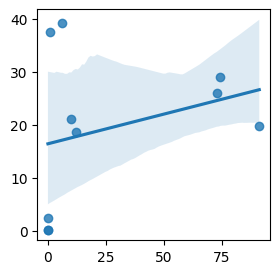

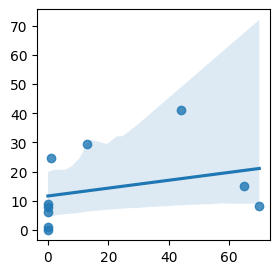

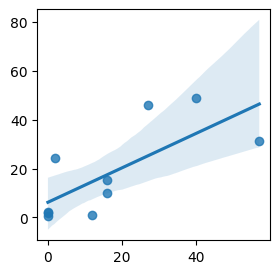

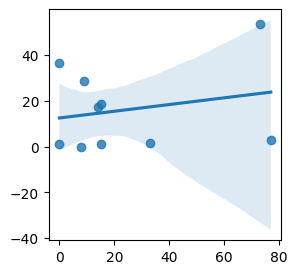

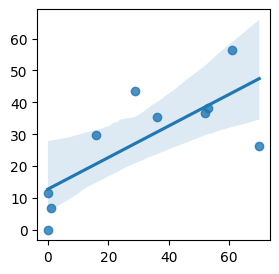

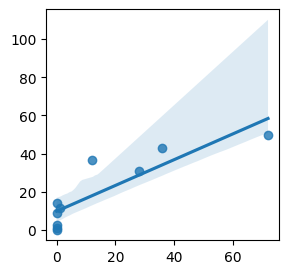

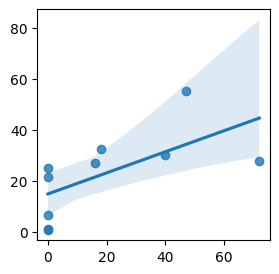

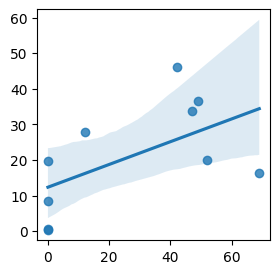

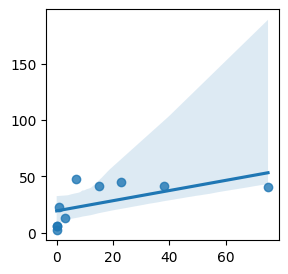

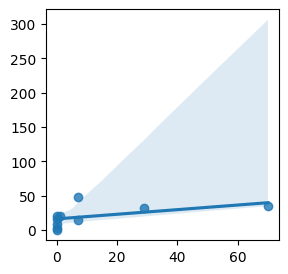

In [36]:
age_samples = get_validation_samples(metadata, filtered_taxonomy, 'age')
age_metadata = metadata[metadata.sample_id.isin(age_samples)] 

age_taxonomy = full_taxonomy.loc[age_samples]
age_taxonomy = age_taxonomy[filtered_taxonomy.columns]
age_taxonomy = np.log(age_taxonomy.div(age_taxonomy.sum(axis=1), axis=0)+1e-3)

age_pathways = full_pathways.loc[age_samples]
age_pathways = age_pathways[filtered_pathways.columns]
age_pathways = np.log(age_pathways.div(age_pathways.sum(axis=1), axis=0)+1e-3)

regression_input = pd.concat([age_metadata[['sample_id', 'age']].set_index('sample_id'), age_taxonomy, age_pathways], axis=1).dropna().sample(100)

X = regression_input.drop('age', axis=1)
X_taxonomy = X[filtered_taxonomy.columns]
X_pathways = X[filtered_pathways.columns]

y = regression_input[['age']].values.reshape(len(regression_input), )

age_taxonomy_tensor = torch.tensor(X_taxonomy.values).float().unsqueeze(-1)#.to(DEVICE)
age_pathways_tensor = torch.tensor(X_pathways.values).float().unsqueeze(-1)#.to(DEVICE)

# use model
xT_pred, xP_pred, mean, logvar, age_z  = model(age_pathways_tensor, age_taxonomy_tensor)

regression_downstream(age_z.cpu().detach().numpy(), y)

In [37]:
from sklearn.decomposition import PCA

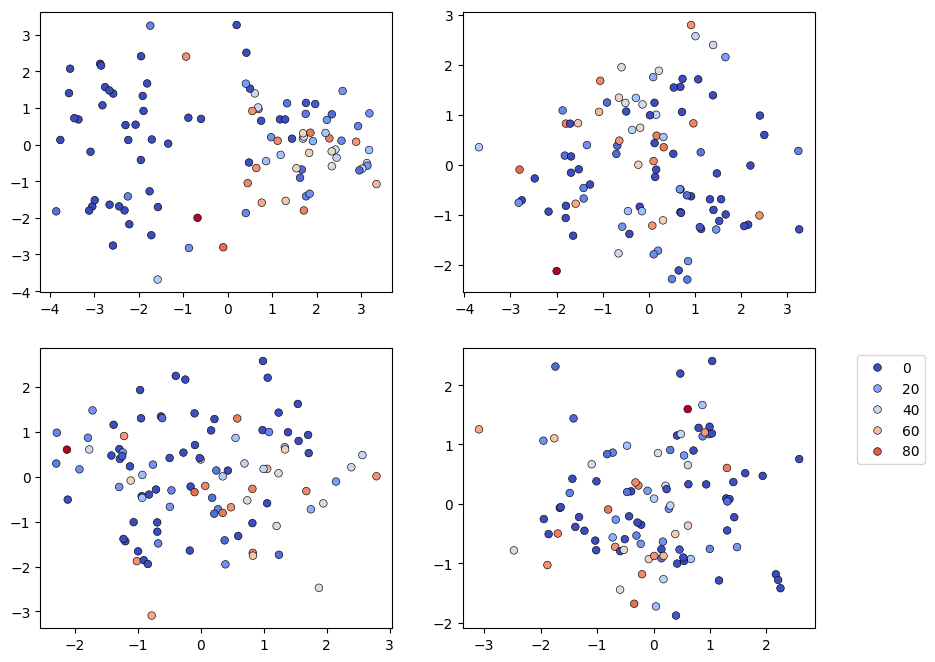

In [38]:
latent = age_z.cpu().detach().numpy()
latent_scaled = StandardScaler().fit_transform(latent)

pca_latent = PCA(n_components=5).fit_transform(latent)

fig, axes = plt.subplots(2, 2, figsize = (10, 8))
sns.scatterplot(x = pca_latent[:, 0], y=pca_latent[:, 1], hue = y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[0, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 1], y=pca_latent[:, 2], hue = y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[0, 1], legend=False)
sns.scatterplot(x = pca_latent[:, 2], y=pca_latent[:, 3], hue = y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[1, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 3], y=pca_latent[:, 4], hue = y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[1, 1])
axes[1, 1].legend(bbox_to_anchor = (1.1, 1))

<Axes: >

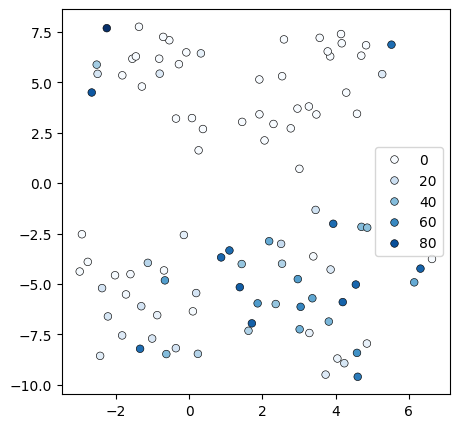

In [39]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,  init='random', perplexity=25).fit_transform(latent)
plt.figure(figsize = (5, 5))
sns.scatterplot(x = X_embedded[:, 0], y=X_embedded[:, 1], hue = y, s=30, edgecolor='k', palette = 'Blues')

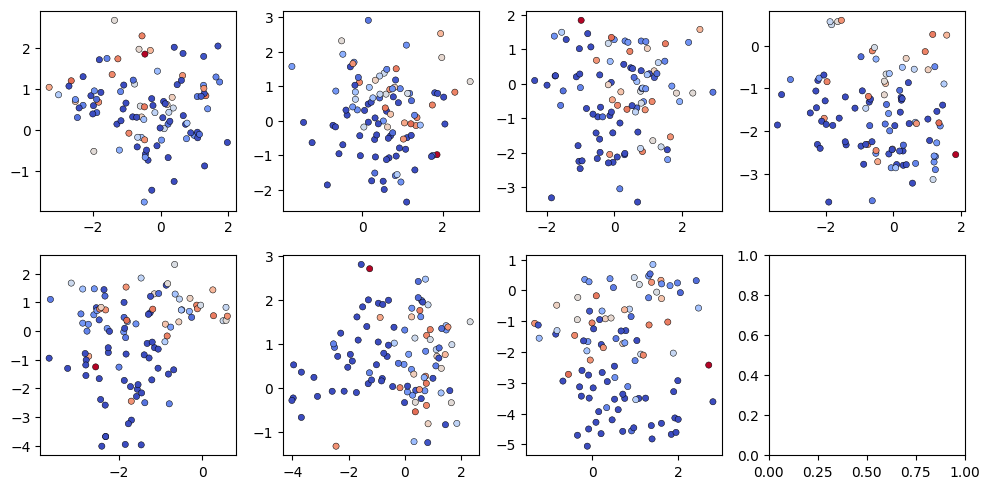

In [40]:
fig, axes = plt.subplots(2, 4, figsize = (10, 5))

sns.scatterplot(x=latent[:, 0], y=latent[:, 1], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 0])
sns.scatterplot(x=latent[:, 1], y=latent[:, 2], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 1])
sns.scatterplot(x=latent[:, 2], y=latent[:, 3], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 2])
sns.scatterplot(x=latent[:, 3], y=latent[:, 4], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 3])
sns.scatterplot(x=latent[:, 4], y=latent[:, 5], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 0])
sns.scatterplot(x=latent[:, 5], y=latent[:, 6], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 1])
sns.scatterplot(x=latent[:, 6], y=latent[:, 7], hue=y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 2])

plt.tight_layout()

<Axes: >

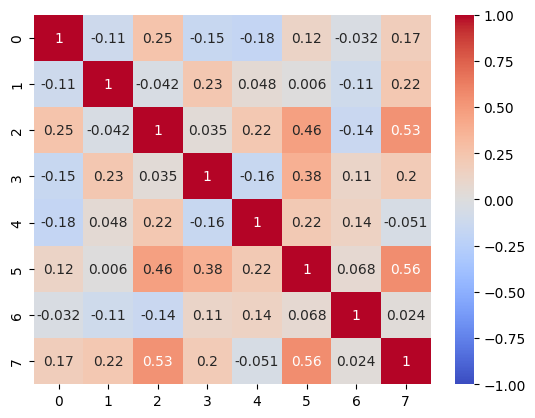

In [41]:
sns.heatmap(pd.DataFrame(latent).corr(), cmap = 'coolwarm', annot=True, vmin=-1, vmax=1)

In [42]:
age_samples = get_validation_samples(metadata, filtered_taxonomy, 'BMI')
age_metadata = metadata[metadata.sample_id.isin(age_samples)] 

age_taxonomy = full_taxonomy.loc[age_samples]
age_taxonomy = age_taxonomy[filtered_taxonomy.columns]
age_taxonomy = np.log(age_taxonomy.div(age_taxonomy.sum(axis=1), axis=0)+1e-3)

age_pathways = full_pathways.loc[age_samples]
age_pathways = age_pathways[filtered_pathways.columns]
age_pathways = np.log(age_pathways.div(age_pathways.sum(axis=1), axis=0)+1e-3)

full_taxonomy = full_taxonomy[~full_taxonomy.index.duplicated(keep='first')]
full_pathways = full_pathways[~full_pathways.index.duplicated(keep='first')]
age_metadata = age_metadata[~age_metadata.sample_id.duplicated(keep='first')]

regression_input = pd.concat([age_metadata[['sample_id', 'BMI']].set_index('sample_id'), full_taxonomy, full_pathways], axis=1).dropna().sample(80)

X = regression_input.drop('BMI', axis=1)
X_taxonomy = X[filtered_taxonomy.columns]
X_pathways = X[filtered_pathways.columns]

bmi_y = regression_input[['BMI']].values.reshape(len(regression_input), )

age_taxonomy_tensor = torch.tensor(X_taxonomy.values).float().unsqueeze(-1)#.to(DEVICE)
age_pathways_tensor = torch.tensor(X_pathways.values).float().unsqueeze(-1)#.to(DEVICE)

# use model
xT_pred, xP_pred, mean, logvar, bmi_z  = model(age_pathways_tensor, age_taxonomy_tensor)

np.float64(0.2705884487385116)

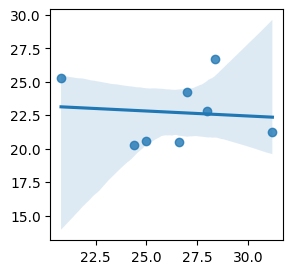

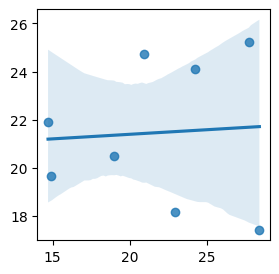

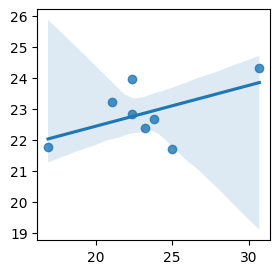

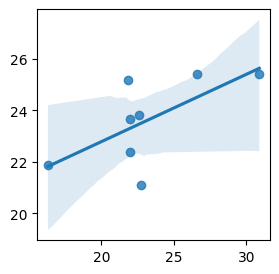

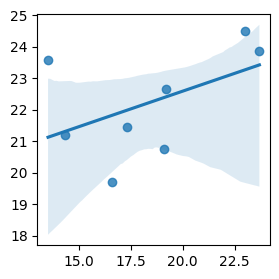

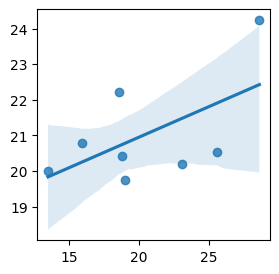

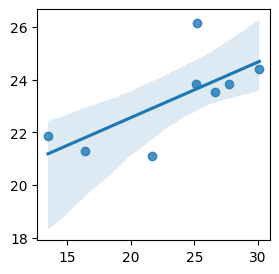

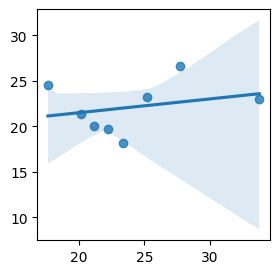

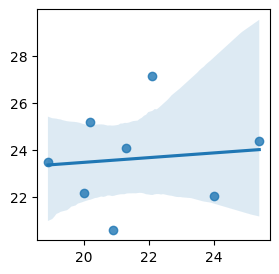

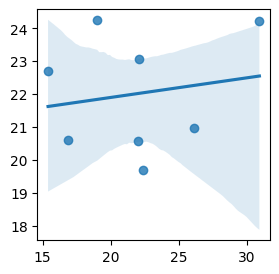

In [43]:
regression_downstream(bmi_z.cpu().detach().numpy(), bmi_y)

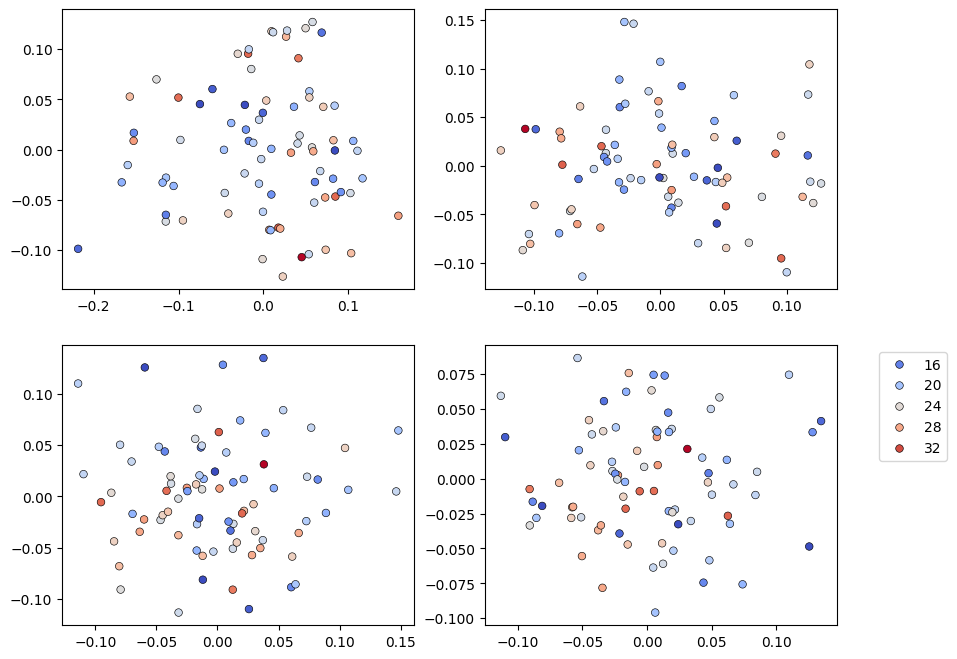

In [44]:
latent = bmi_z.cpu().detach().numpy()
latent_scaled = StandardScaler().fit_transform(latent)

pca_latent = PCA(n_components=5).fit_transform(latent)

fig, axes = plt.subplots(2, 2, figsize = (10, 8))
sns.scatterplot(x = pca_latent[:, 0], y=pca_latent[:, 1], hue = bmi_y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[0, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 1], y=pca_latent[:, 2], hue = bmi_y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[0, 1], legend=False)
sns.scatterplot(x = pca_latent[:, 2], y=pca_latent[:, 3], hue = bmi_y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[1, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 3], y=pca_latent[:, 4], hue = bmi_y, s=30, edgecolor='k', palette = 'coolwarm', ax=axes[1, 1])
axes[1, 1].legend(bbox_to_anchor = (1.1, 1))

<Axes: >

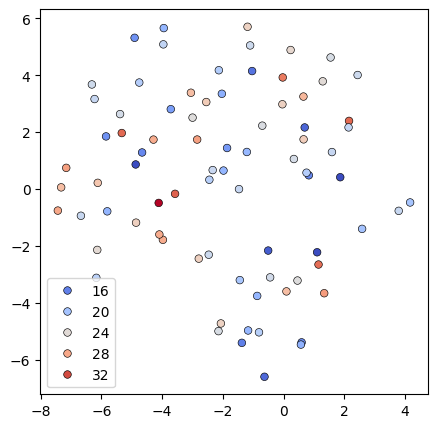

In [45]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,  init='random', perplexity=25).fit_transform(latent)
plt.figure(figsize = (5, 5))
sns.scatterplot(x = X_embedded[:, 0], y=X_embedded[:, 1], hue = bmi_y, s=30, edgecolor='k', palette = 'coolwarm')

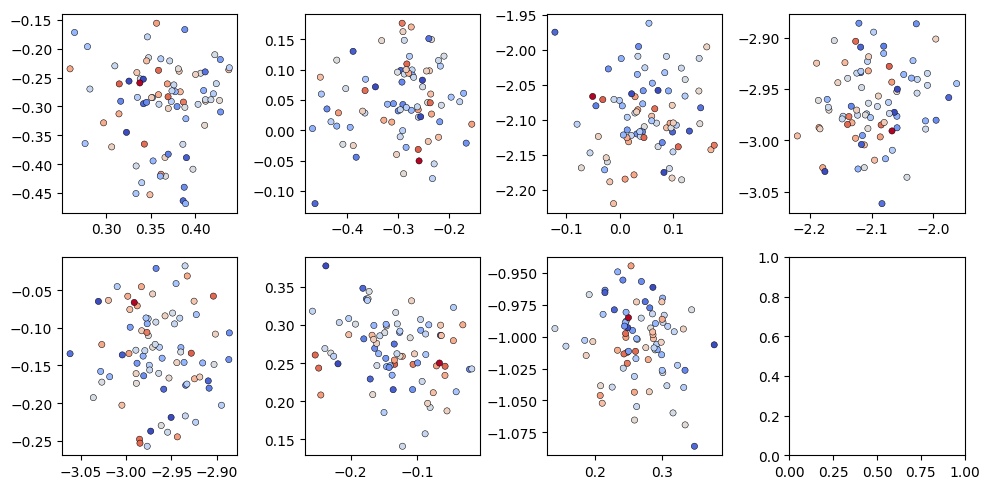

In [46]:
fig, axes = plt.subplots(2, 4, figsize = (10, 5))

sns.scatterplot(x=latent[:, 0], y=latent[:, 1], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 0])
sns.scatterplot(x=latent[:, 1], y=latent[:, 2], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 1])
sns.scatterplot(x=latent[:, 2], y=latent[:, 3], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 2])
sns.scatterplot(x=latent[:, 3], y=latent[:, 4], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[0, 3])
sns.scatterplot(x=latent[:, 4], y=latent[:, 5], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 0])
sns.scatterplot(x=latent[:, 5], y=latent[:, 6], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 1])
sns.scatterplot(x=latent[:, 6], y=latent[:, 7], hue=bmi_y, palette='coolwarm', legend=False, edgecolor='k', s=20, ax=axes[1, 2])

plt.tight_layout()

In [47]:
del xT_pred, xP_pred, mean, logvar, bmi_z

## SICK vs HEALTHY

In [48]:
def health_prediction(X, y):
        
    rf = RandomForestClassifier()
    
    scoring = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'auc': 'roc_auc'
    }

    kfold = StratifiedKFold(n_splits=5)  # Adjust n_splits as needed

    cv_results = cross_validate(rf, X, y, cv=kfold, scoring=scoring, return_train_score=False)
    
    mean_precision = cv_results['test_precision'].mean()
    mean_recall = cv_results['test_recall'].mean()
    mean_auc = cv_results['test_auc'].mean()

    return mean_auc, mean_precision, mean_recall

In [49]:
val_metadata = metadata[~metadata.sample_id.isin(filtered_taxonomy.index)][['sample_id', 'SICK', 'study_condition']].dropna()
val_metadata = val_metadata[val_metadata['study_condition'].isin(["IBD", "control"])]
age_samples = val_metadata[val_metadata['SICK'] == 0]['sample_id'].sample(100).tolist() + val_metadata[val_metadata['SICK'] == 1]['sample_id'].sample(100).tolist()

age_taxonomy = full_taxonomy.loc[age_samples]
age_taxonomy = age_taxonomy[filtered_taxonomy.columns]
age_taxonomy = np.log(age_taxonomy.div(age_taxonomy.sum(axis=1), axis=0)+1e-3)

age_pathways = full_pathways.loc[age_samples]
age_pathways = age_pathways[filtered_pathways.columns]
age_pathways = np.log(age_pathways.div(age_pathways.sum(axis=1), axis=0)+1e-3)

val_metadata = val_metadata[val_metadata['sample_id'].isin(age_samples)]

val_metadata = val_metadata[['sample_id', 'SICK']].set_index('sample_id')
val_metadata = val_metadata[~val_metadata.index.duplicated(keep='first')]
age_pathways = age_pathways[~age_pathways.index.duplicated(keep='first')]
age_taxonomy = age_taxonomy[~age_taxonomy.index.duplicated(keep='first')]

regression_input = pd.concat([val_metadata, age_taxonomy, age_pathways], axis=1).dropna()

X_taxonomy = regression_input.drop('SICK', axis=1).iloc[:, :len(age_taxonomy.columns)]
X_pathways = regression_input.drop('SICK', axis=1).iloc[:, len(age_taxonomy.columns):]

health_y = regression_input[['SICK']].values.reshape(len(regression_input), )

X_val_taxonomy_tensor = torch.tensor(X_taxonomy.values).float()
X_val_taxonomy_tensor = X_val_taxonomy_tensor.unsqueeze(-1)  

X_val_pathways_tensor = torch.tensor(X_pathways.values).float()
X_val_pathways_tensor = X_val_pathways_tensor.unsqueeze(-1)  

detached_model = model.cpu()
xT_pred_val, xP_pred_val, mean, logvar, health_z = detached_model(X_val_pathways_tensor, X_val_taxonomy_tensor)

In [50]:
health_prediction(health_z.cpu().detach().numpy(), health_y)

(np.float64(0.7505263157894737),
 np.float64(0.7076282051282051),
 np.float64(0.6210526315789473))

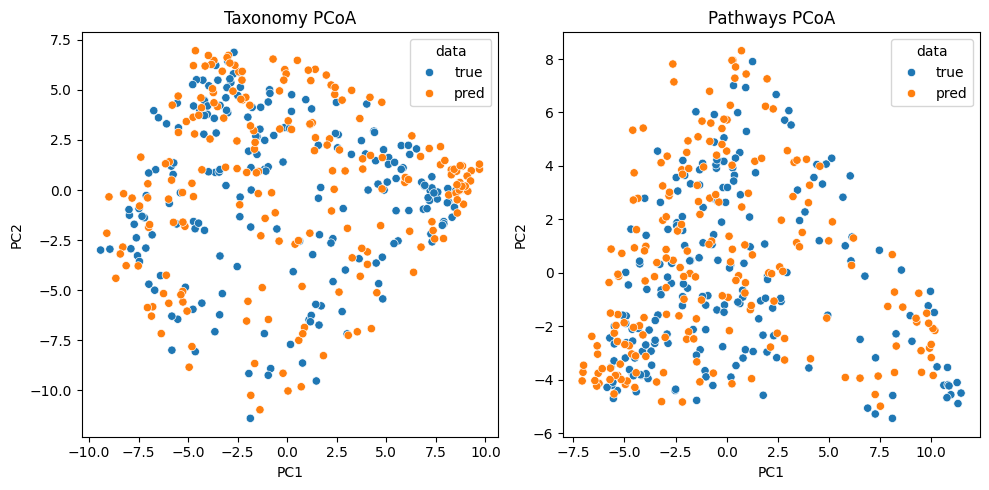

In [51]:
# Prepare PCoA results for both taxonomy and pathways
pcoa_df_taxonomy, taxonomy_labels = prepare_pcoa_df(X_taxonomy, pd.DataFrame(xT_pred_val[:, :, 0].cpu().detach().numpy(), columns = X_taxonomy.columns, index=X_taxonomy.index), 'taxonomy')
pcoa_df_pathways, pathways_labels = prepare_pcoa_df(X_pathways, pd.DataFrame(xP_pred_val[:, :, 0].cpu().detach().numpy(), columns = X_pathways.columns, index=X_pathways.index), 'pathways')

# Create subplots for taxonomy and pathways
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot PCoA for taxonomy
sns.scatterplot(x=pcoa_df_taxonomy.PC1, y=pcoa_df_taxonomy.PC2, hue=taxonomy_labels, ax=axes[0])
axes[0].set_title('Taxonomy PCoA')

# Plot PCoA for pathways
sns.scatterplot(x=pcoa_df_pathways.PC1, y=pcoa_df_pathways.PC2, hue=pathways_labels, ax=axes[1])
axes[1].set_title('Pathways PCoA')

plt.tight_layout()
plt.show()

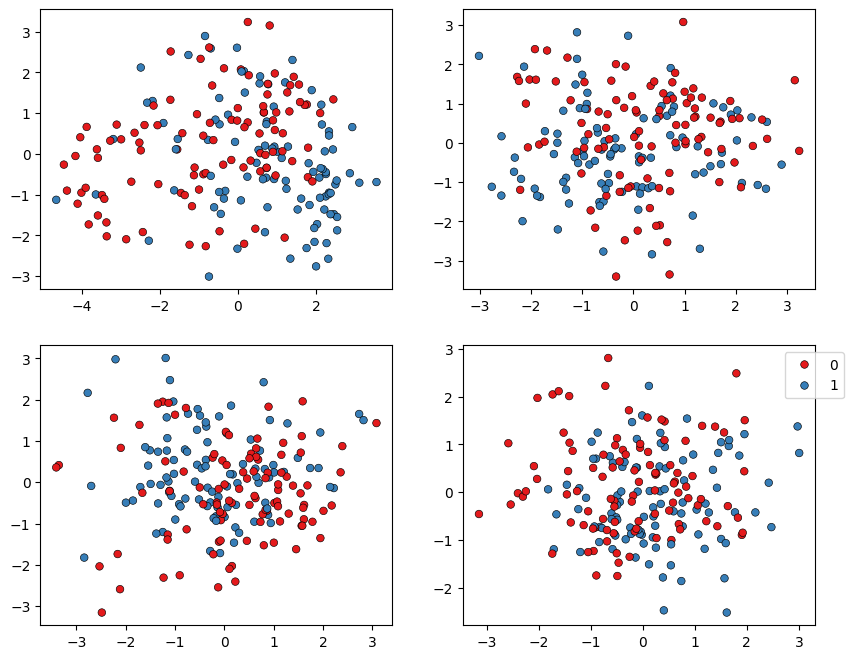

In [52]:
from sklearn.decomposition import PCA

latent = np.nan_to_num(health_z.cpu().detach().numpy())
latent_scaled = StandardScaler().fit_transform(latent)

pca_latent = PCA(n_components=5).fit_transform(latent)

fig, axes = plt.subplots(2, 2, figsize = (10, 8))
sns.scatterplot(x = pca_latent[:, 0], y=pca_latent[:, 1], hue = health_y, s=30, edgecolor='k', palette = 'Set1', ax=axes[0, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 1], y=pca_latent[:, 2], hue = health_y, s=30, edgecolor='k', palette = 'Set1', ax=axes[0, 1], legend=False)
sns.scatterplot(x = pca_latent[:, 2], y=pca_latent[:, 3], hue = health_y, s=30, edgecolor='k', palette = 'Set1', ax=axes[1, 0], legend=False)
sns.scatterplot(x = pca_latent[:, 3], y=pca_latent[:, 4], hue = health_y, s=30, edgecolor='k', palette = 'Set1', ax=axes[1, 1])
axes[1, 1].legend(bbox_to_anchor = (1.1, 1))

<Axes: >

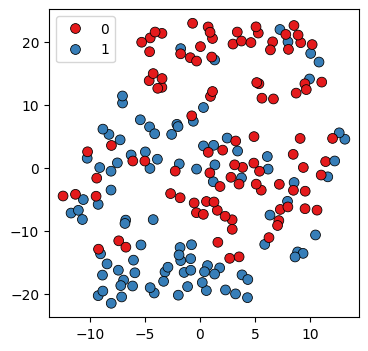

In [53]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2,  init='random', perplexity=20).fit_transform(latent)
plt.figure(figsize = (4, 4))
sns.scatterplot(x = X_embedded[:, 0], y=X_embedded[:, 1], hue = health_y, s=50, edgecolor='k', palette = 'Set1')

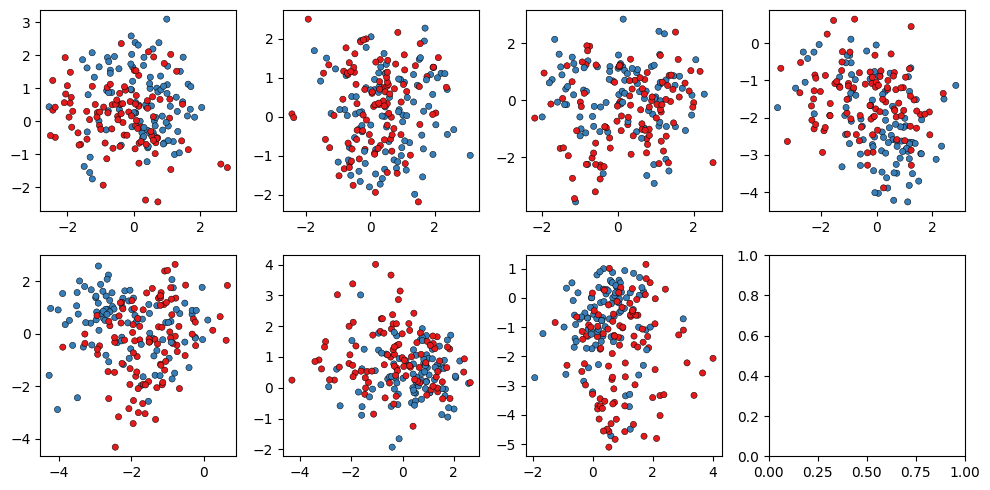

In [54]:
fig, axes = plt.subplots(2, 4, figsize = (10, 5))

sns.scatterplot(x=latent[:, 0], y=latent[:, 1], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[0, 0])
sns.scatterplot(x=latent[:, 1], y=latent[:, 2], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[0, 1])
sns.scatterplot(x=latent[:, 2], y=latent[:, 3], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[0, 2])
sns.scatterplot(x=latent[:, 3], y=latent[:, 4], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[0, 3])
sns.scatterplot(x=latent[:, 4], y=latent[:, 5], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[1, 0])
sns.scatterplot(x=latent[:, 5], y=latent[:, 6], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[1, 1])
sns.scatterplot(x=latent[:, 6], y=latent[:, 7], hue=health_y, palette='Set1', legend=False, edgecolor='k', s=20, ax=axes[1, 2])

plt.tight_layout()